## Prediksi Gempa Berdasarkan Data Dari USGS Menggunakan Klasifikasi Model Decision Tree

### Dibuat oleh Kelompok 1 Universitas Singeperbangsa Karawang, Fakultas Ilmu Komputer, Informatika:
### 1.   Farrel Paksi Aditya (2210631170068)
### 2.   Nabila Putri Asy Syifa (2210631170036)

In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import graphviz
from sklearn.tree import plot_tree

In [80]:
# Langkah 1: Memuat Dataset
# Gantilah 'path_to_your_dataset.csv' dengan path ke file dataset Anda
df = pd.read_csv('EarthQuakeUSGS.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9451 entries, 0 to 9450
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             9451 non-null   object 
 1   latitude         9451 non-null   float64
 2   longitude        9451 non-null   float64
 3   depth            9451 non-null   float64
 4   mag              9451 non-null   float64
 5   magType          9451 non-null   object 
 6   nst              7319 non-null   float64
 7   gap              7319 non-null   float64
 8   dmin             6175 non-null   float64
 9   rms              9451 non-null   float64
 10  net              9451 non-null   object 
 11  id               9451 non-null   object 
 12  updated          9451 non-null   object 
 13  place            9451 non-null   object 
 14  type             9451 non-null   object 
 15  horizontalError  6462 non-null   float64
 16  depthError       9451 non-null   float64
 17  magError      

In [81]:
# Drop kolom yang tidak digunakan
columns_to_drop = ['time','net','magType', 'nst', 'gap', 'dmin', 'rms', 'id', 'updated', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource']
df = df.drop(columns=columns_to_drop)

In [82]:
# Menampilkan dataframe yang telah dibersihkan dengan ketentuan 10 baris pertama
df.head(10)

,latitude,longitude,depth,mag,place
0,31.604000,-104.213000,4.4198,1.70,"51 km NW of Toyah, Texas"
1,64.501000,-146.905800,4.2000,1.40,"2 km S of Salcha, Alaska"
2,63.529000,-147.554300,13.1000,1.60,"71 km ESE of Denali Park, Alaska"
3,38.833168,-122.797165,1.7300,0.40,"6 km W of Cobb, CA"
4,63.546200,-150.971900,0.0000,1.20,"37 km E of Denali National Park, Alaska"
5,19.265499,-155.456665,30.0000,1.83,"7 km NNE of Pāhala, Hawaii"
6,31.738000,-104.124000,4.5509,2.00,"49 km W of Mentone, Texas"
7,38.821999,-122.796997,2.0800,0.74,"6 km NW of The Geysers, CA"
8,19.704500,-64.647100,59.0000,3.93,"152 km N of Cruz Bay, U.S. Virgin Islands"
9,57.839800,-156.350500,129.8000,2.00,"72 km ENE of Ugashik, Alaska"


In [83]:
# Langkah 2: Membersihkan dan Menyiapkan Data
# Misalnya, kita hanya akan menggunakan kolom latitude, longitude, depth, dan magnitude untuk deteksi
# Mengubah target menjadi binary (misalnya: magnitude >= 5 dianggap gempa besar, lainnya gempa kecil)
df['is_major'] = df['mag'].apply(lambda x: 1 if x >= 5 else 0)

# Mengkategorikan tingkat kerusakan berdasarkan depth dan lokasi
def damage_assessment(row):
    if row['depth'] < 70:
        if row['mag'] >= 5:
            return 'High'
        elif 3 <= row['mag'] < 5:
            return 'Medium'
        else:
            return 'Low'
    else:
        if row['mag'] >= 6:
            return 'Medium'
        else:
            return 'Low'

df['damage_level'] = df.apply(damage_assessment, axis=1)

# Menentukan fitur dan target
features = df[['latitude', 'longitude', 'depth', 'mag']]
target_major = df['is_major']
target_location = df['place']
target_damage = df['damage_level']

In [84]:
# Menampilkan dataframe yang telah dibersihkan dan ditambahkan kolom is_major dan damage_level
# dengan ketentuan 10 baris pertama
df.head(10)

,latitude,longitude,depth,mag,place,is_major,damage_level
0,31.604000,-104.213000,4.4198,1.70,"51 km NW of Toyah, Texas",0,Low
1,64.501000,-146.905800,4.2000,1.40,"2 km S of Salcha, Alaska",0,Low
2,63.529000,-147.554300,13.1000,1.60,"71 km ESE of Denali Park, Alaska",0,Low
3,38.833168,-122.797165,1.7300,0.40,"6 km W of Cobb, CA",0,Low
4,63.546200,-150.971900,0.0000,1.20,"37 km E of Denali National Park, Alaska",0,Low
5,19.265499,-155.456665,30.0000,1.83,"7 km NNE of Pāhala, Hawaii",0,Low
6,31.738000,-104.124000,4.5509,2.00,"49 km W of Mentone, Texas",0,Low
7,38.821999,-122.796997,2.0800,0.74,"6 km NW of The Geysers, CA",0,Low
8,19.704500,-64.647100,59.0000,3.93,"152 km N of Cruz Bay, U.S. Virgin Islands",0,Medium
9,57.839800,-156.350500,129.8000,2.00,"72 km ENE of Ugashik, Alaska",0,Low


In [85]:
# Membagi data menjadi training dan testing set untuk prediksi gempa besar
X_train_major, X_test_major, y_train_major, y_test_major = train_test_split(features, target_major, test_size=0.3, random_state=42)

# # Membagi data menjadi training dan testing set untuk prediksi lokasi
X_train_location, X_test_location, y_train_location, y_test_location = train_test_split(features, target_location, test_size=0.3, random_state=42)

# Membagi data menjadi training dan testing set untuk prediksi kerusakan
X_train_damage, X_test_damage, y_train_damage, y_test_damage = train_test_split(features, target_damage, test_size=0.3, random_state=42)

In [86]:
# Langkah 3: Membangun Model Decision Tree
clf_major = DecisionTreeClassifier()
clf_location = DecisionTreeClassifier()
clf_damage = DecisionTreeClassifier()

# Langkah 4: Melatih Model
clf_major.fit(X_train_major, y_train_major)
clf_location.fit(X_train_location, y_train_location)
clf_damage.fit(X_train_damage, y_train_damage)

# Langkah 5.1: Menguji Model untuk prediksi gempa besar
y_pred_major = clf_major.predict(X_test_major)
print("Accuracy for Major Earthquake Prediction:", round(accuracy_score(y_test_major, y_pred_major),3))
# print("Classification Report for Major Earthquake Prediction:\n", classification_report(y_test_major, y_pred_major))

# Langkah 5.2: Menguji Model untuk prediksi lokasi
y_pred_location = clf_location.predict(X_test_location)
print("Accuracy for Location Prediction:", round(accuracy_score(y_test_location, y_pred_location),3))
# print("Classification Report for Location Prediction:\n", classification_report(y_test_location, y_pred_location))

# Langkah 6: Menguji Model untuk prediksi kerusakan
y_pred_damage = clf_damage.predict(X_test_damage)
print("Accuracy for Damage Level Prediction:", round(accuracy_score(y_test_damage, y_pred_damage),3))
# print("Classification Report for Damage Level Prediction:\n", classification_report(y_test_damage, y_pred_damage))

Accuracy for Major Earthquake Prediction: 1.0
Accuracy for Location Prediction: 0.323
Accuracy for Damage Level Prediction: 1.0


c:\Users\Farrel Paksi Aditya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Farrel Paksi Aditya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\Farrel Paksi Aditya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Input Value:
Latitude:  19.345  Longitude:  -89.321  Depth:  45.66  Magnitude:  3.66 

Prediction for new data:
Minor earthquake
Location: 28 km S of La Libertad, El Salvador
Damage level: Medium


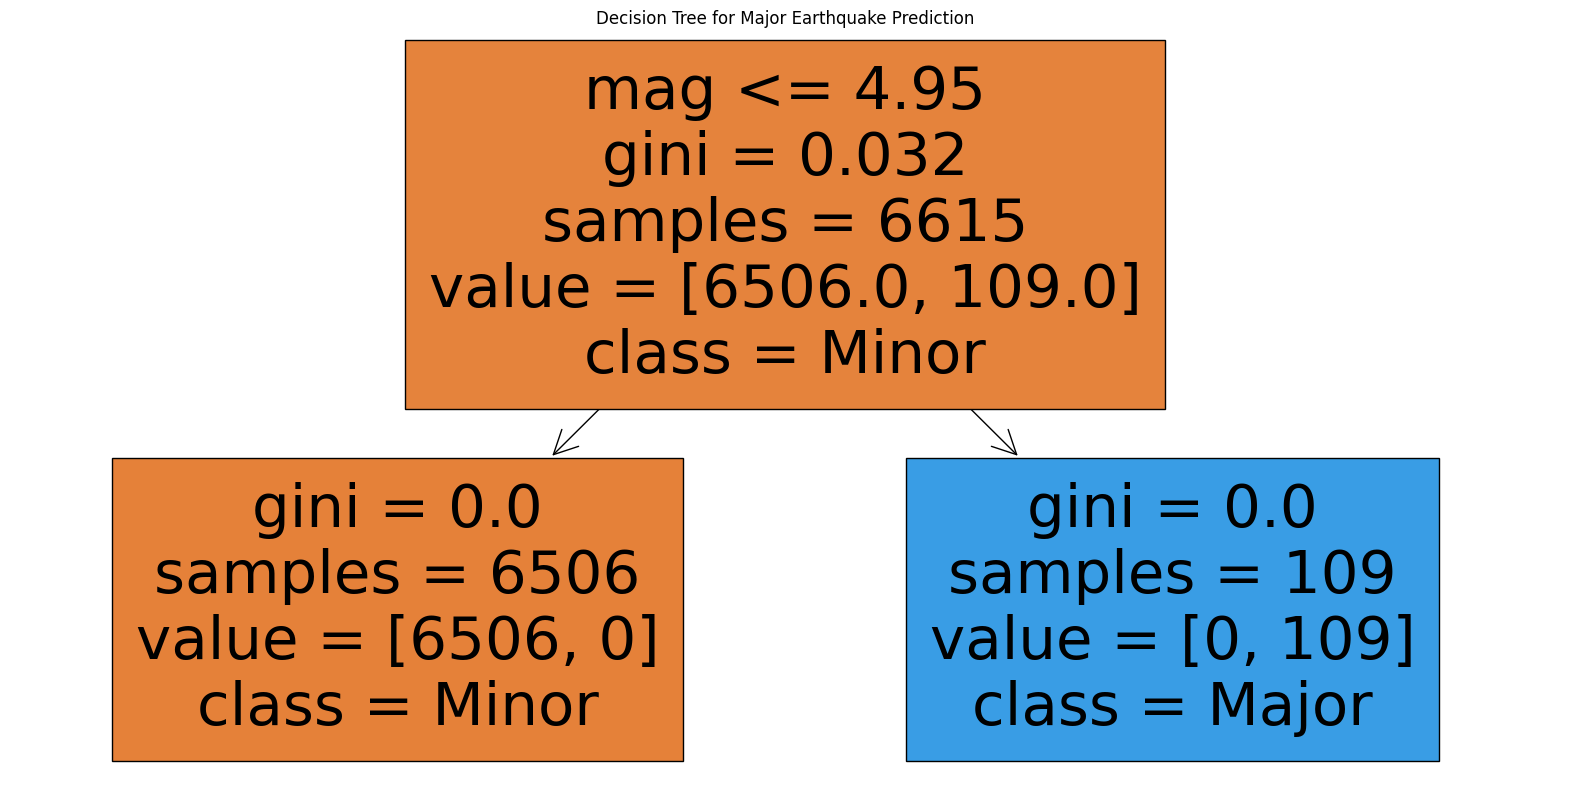

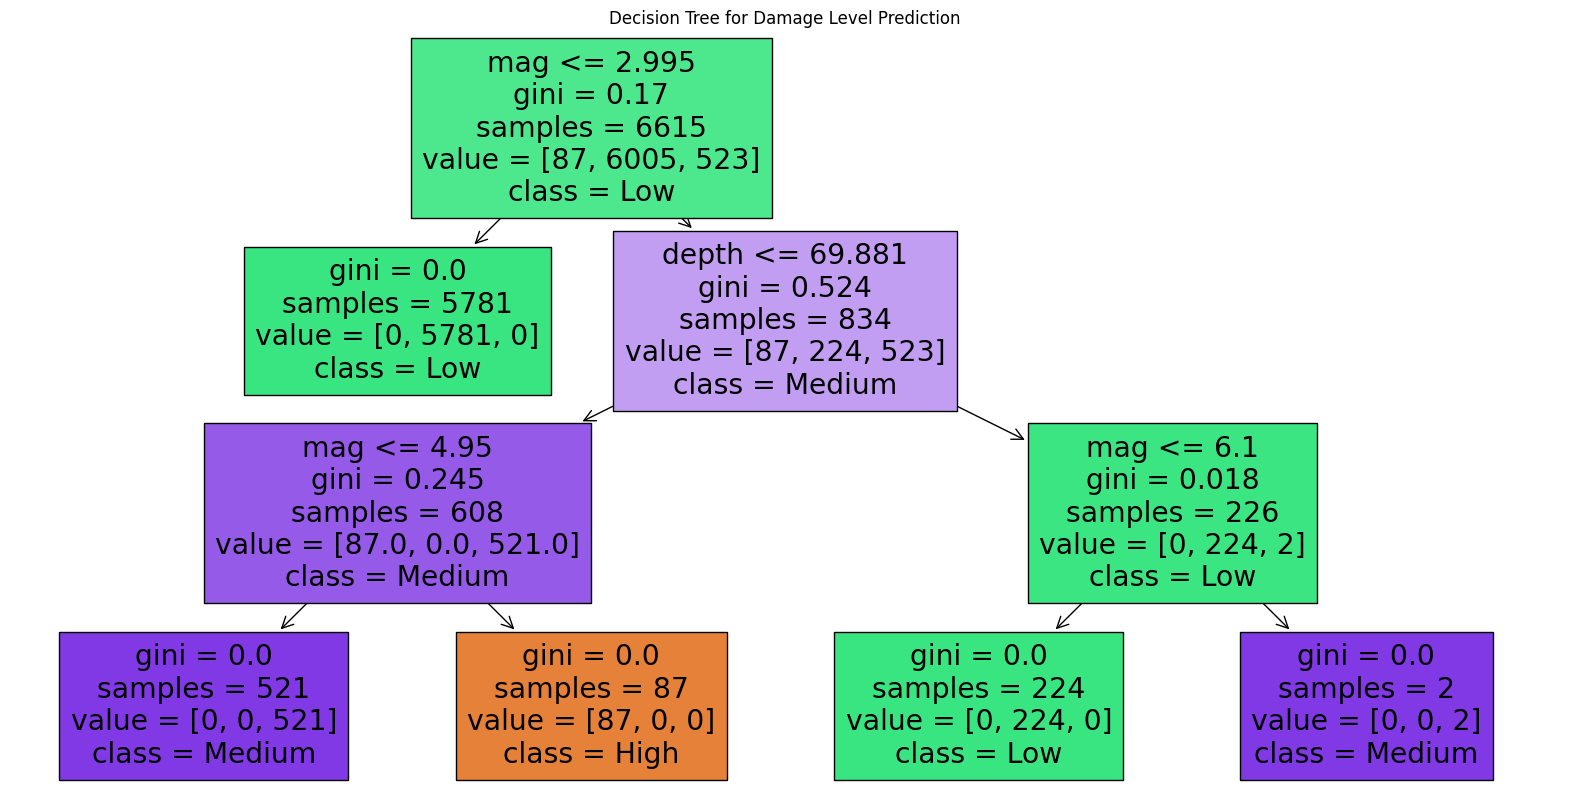

In [87]:
# Contoh prediksi baru dengan input dari pengguna
latitude = float(input("Enter latitude: "))
longitude = float(input("Enter longitude: "))
depth = float(input("Enter depth: "))
magnitude = float(input("Enter magnitude: "))

new_data = np.array([[latitude, longitude, depth, magnitude]])  # Data gempa baru (latitude, longitude, depth, magnitude)
# new_data = np.array([[37.75, -122.68, 10.0, 4.5]])  # Data gempa baru (latitude, longitude, depth, magnitude)
prediction_major = clf_major.predict(new_data)
prediction_location = clf_location.predict(new_data)
prediction_damage = clf_damage.predict(new_data)

print("Input Value:")
print("Latitude: ",latitude," Longitude: ", longitude," Depth: ", depth, " Magnitude: ", magnitude, "\n")
print("Prediction for new data:")
print("Major earthquake" if prediction_major[0] == 1 else "Minor earthquake")
print("Location:", prediction_location[0])
print("Damage level:", prediction_damage[0])

# Langkah 6: Menampilkan dan Menyimpan Decision Tree
# Untuk prediksi gempa besar atau kecil
plt.figure(figsize=(20,10))
plot_tree(clf_major, feature_names=['latitude', 'longitude', 'depth', 'mag'], class_names=['Minor', 'Major'], filled=True)
plt.title("Decision Tree for Major Earthquake Prediction")
plt.savefig('decision_tree_major_earthquake.png')
plt.show()

# Untuk prediksi kerusakan
plt.figure(figsize=(20,10))
plot_tree(clf_damage, feature_names=['latitude', 'longitude', 'depth', 'mag'], class_names=clf_damage.classes_, filled=True)
plt.title("Decision Tree for Damage Level Prediction")
plt.savefig('decision_tree_damage.png')
plt.show()

In [88]:
# Menampilkan nilai pada dataframe berdasarkan lokasinya
df[df['place'] == prediction_location[0]]


,latitude,longitude,depth,mag,place,is_major,damage_level
66,13.23,-89.3653,80.769,4.7,"28 km S of La Libertad, El Salvador",0,Low
